In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [2]:
import multiprocessing as mp
import numpy as np
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm

### Define General Setting

In [16]:
d = 1000
N = 100

In [4]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [5]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

# reshape 
X_train = X_train.transpose()
X_test = X_test.transpose()
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [6]:
y_train.shape, X_train.shape

((1, 100), (1000, 100))

### Define Unbiased U-V model

In [11]:
def symmetric_init(alpha, s, d):
    """ initialize model weights """
    norm_u = np.sqrt(alpha * (1 - s) / (1 + s))
    norm_v = np.sqrt(alpha * (1 + s) / (1 - s))

    u_0 = np.ones((d, 1)) * norm_u
    v_0 = np.ones((d, 1)) * norm_v

    u_p_0 = u_n_0 = u_0
    v_p_0 = v_n_0 = v_0
    return u_p_0, v_p_0, u_n_0, v_n_0


def update(u_p, v_p, u_n, v_n, x, y, step_size):
    """ perform gradient decsent """
    d, n = x.shape

    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    grad_r = -(y_pred - y)/n

    grad_xr = np.matmul(x, grad_r.transpose())

    u_p_grad = np.multiply(grad_xr, v_p)
    v_p_grad = np.multiply(grad_xr, u_p)
    u_n_grad = -np.multiply(grad_xr, v_n)
    v_n_grad = -np.multiply(grad_xr, u_n)

    u_p = u_p + step_size * u_p_grad
    v_p = v_p + step_size * v_p_grad
    u_n = u_n + step_size * u_n_grad
    v_n = v_n + step_size * v_n_grad

    return u_p, v_p, u_n, v_n


def current_training_loss(u_p, v_p, u_n, v_n, x, y):
    d, n = x.shape
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    return np.linalg.norm(y - y_pred, ord=2) ** 2 / n

In [12]:
def train(u_p_0, v_p_0, u_n_0, v_n_0, x, y, step_size, n_epochs, eval_freq=1000, early_stop_tol=1e-4):
    training_loss = []
    u_p_array = []
    v_p_array = []
    u_n_array = []
    v_n_array = []

    u_p, v_p, u_n, v_n = np.array(u_p_0), np.array(v_p_0), np.array(u_n_0), np.array(v_n_0)

    for epoch in tqdm(range(n_epochs)):

        u_p_updated, v_p_updated, u_n_updated, v_n_updated = update(u_p, v_p, u_n, v_n, x, y, step_size)

        if (epoch + 1) % eval_freq == 0:
            # store learned weights
            training_loss.append(current_training_loss(u_p, v_p, u_n, v_n, x, y))
            u_p_array.append(u_p.copy())
            v_p_array.append(v_p.copy())
            u_n_array.append(u_n.copy())
            v_n_array.append(v_n.copy())

            if training_loss[-1] < early_stop_tol:
                break

        u_p, v_p, u_n, v_n = u_p_updated, v_p_updated, u_n_updated, v_n_updated

    return {
        'u_p': u_p_array,
        'v_p': v_p_array,
        'u_n': u_n_array,
        'v_n': v_n_array,
        'training_loss': training_loss
    }

### Effect of Shape and Scale

In [13]:
alpha_range = np.logspace(-5, -0.6, 20)
s_range = [0, 0.5, 0.7, 0.9, 0.99]

In [ ]:
results = {}
for s in s_range:
    for alpha in alpha_range:
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)
        results[(s, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=1e-3,
            n_epochs=int(1e7),
            early_stop_tol=1e-4)

In [18]:
test_loss = {}

for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)

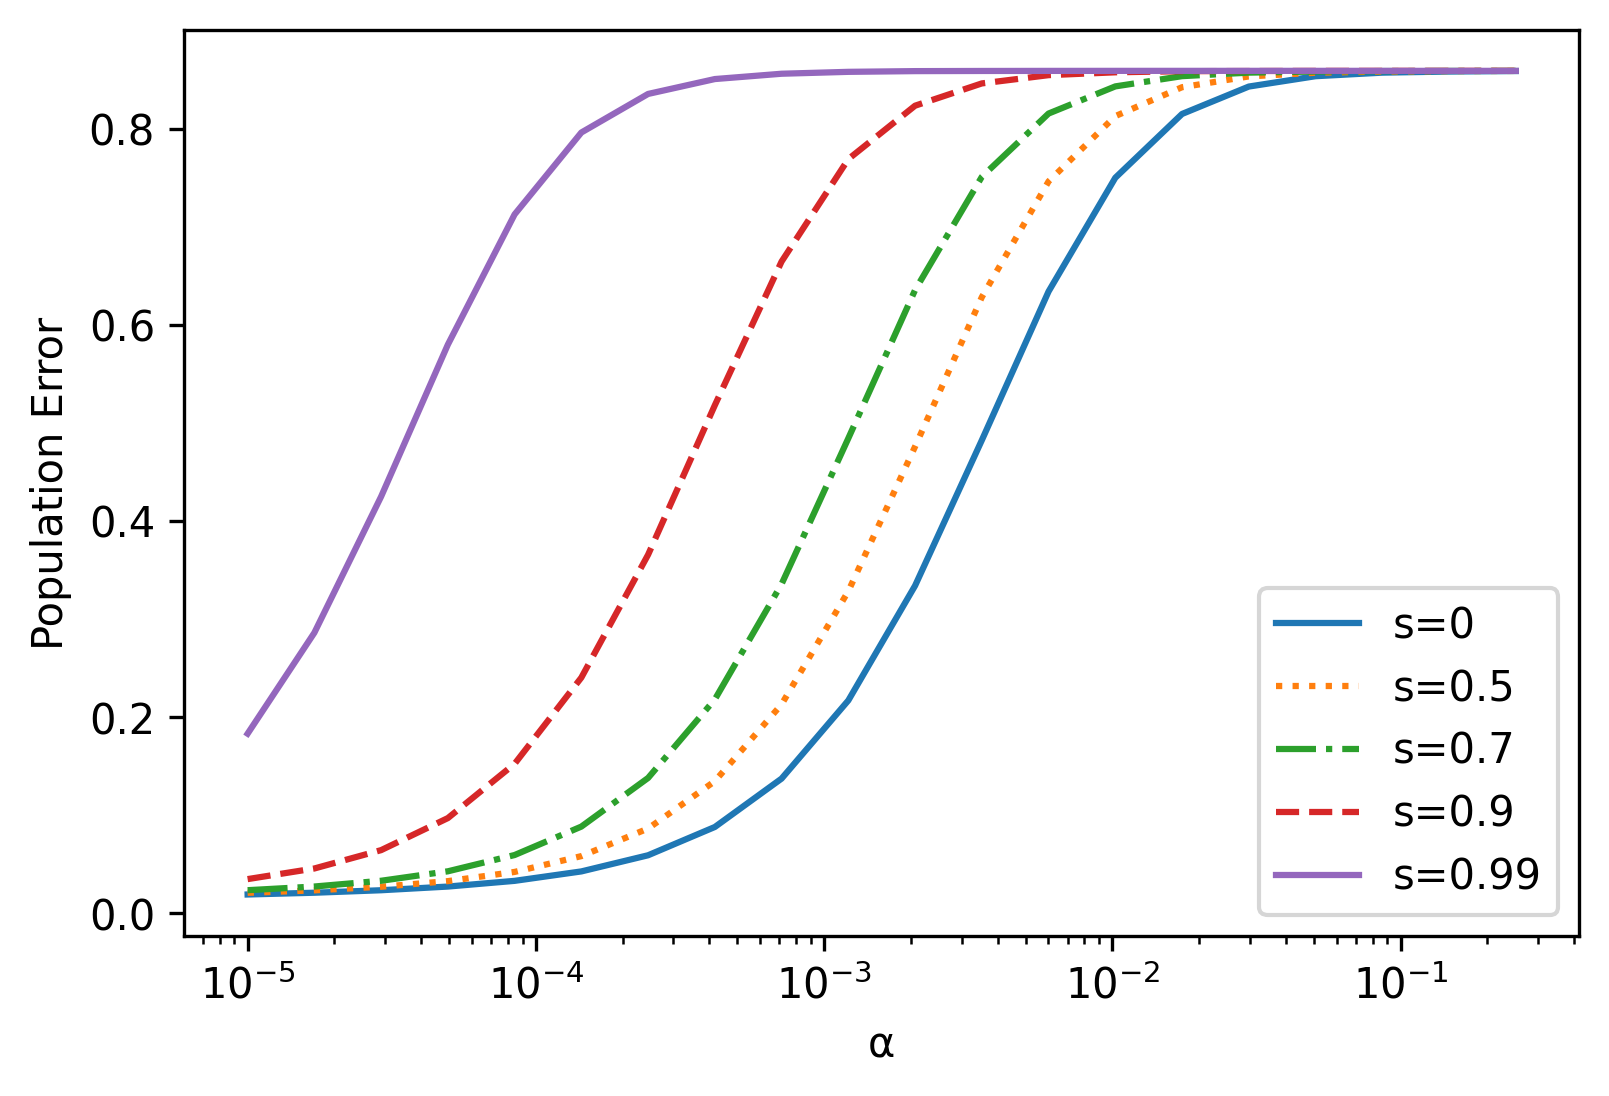

In [21]:
linstyles = ['', ':', '-.', '--', '-']

for s, style in zip(s_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == s], style)
    
legend([f's={s}' for s in s_range])
ylabel('Population Error')
xlabel('α')
xscale('log')

### Effect Of Learning Rate

In [24]:
alpha_range = np.logspace(-5, -0.6, 20)
step_size_range = [1e-3, 1e-2]
s = 0.9

In [ ]:
results = {}
for step_size in step_size_range:
    for alpha in alpha_range:
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)
        results[(step_size, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=step_size,
            n_epochs=int(1e7),
            early_stop_tol=1e-4)

In [30]:
test_loss = {}

for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)

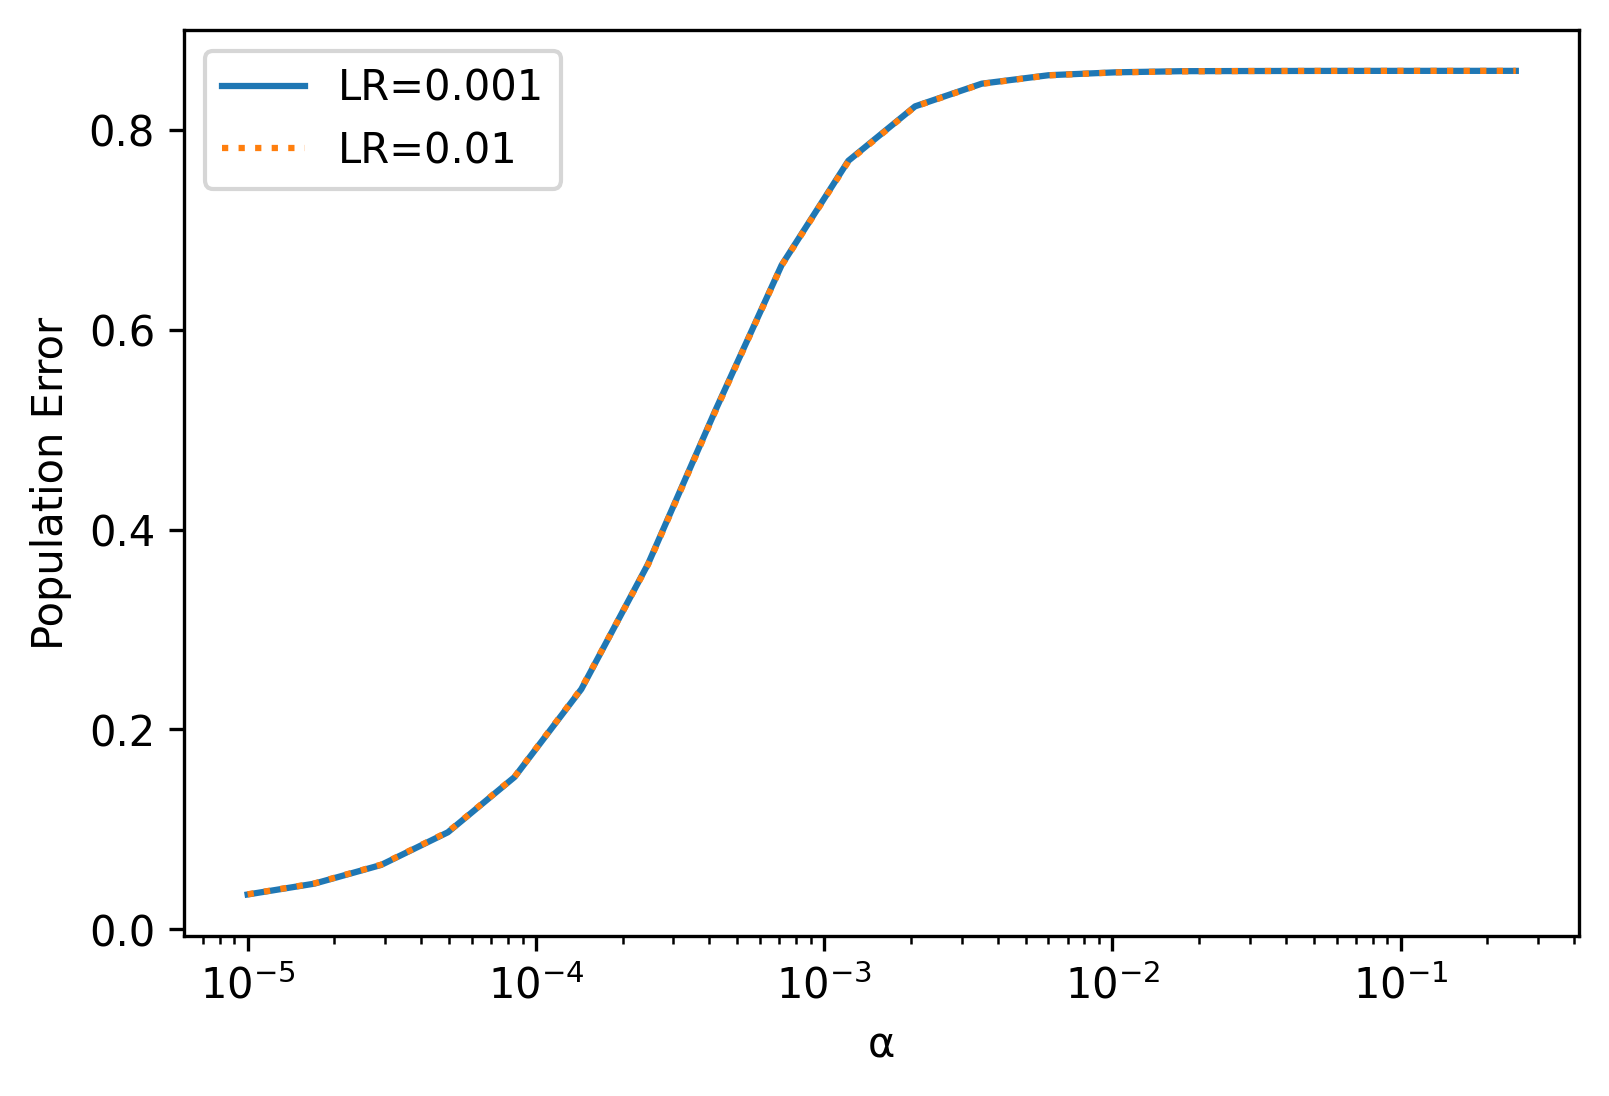

In [33]:
linstyles = ['', ':']

for step_size, style in zip(step_size_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == step_size], style)
    
legend([f'LR={step_size}' for step_size in step_size_range])
ylabel('Population Error')
xlabel('α')
xscale('log')